# 15388 Project - Analysis of Restaurant Reviews

## Introduction

Restaurant reviews and ratings are major factors for many people when they decide where to eat. In fact, study has shown that a one star increase in Yelp rating leads to a 5-9 percent increase in revenue for independent restaurants. But when making use of these reviews, we usually inspect just a fraction of them for a couple restaurants at a time - almost insignificant compared to all the reviews available. This observation motivates our report: can we draw inferences from a large collection of reviews and ratings?

More specifically, in addition to exploring the data through EDA, we would like to investigate several questions. What do people look for in restaurants, and what drives them away? Can people have different preferences for different cuisines? These may yield valuable insights for restaurants seeking improvements and more renevue. 

To answer these questions, we decided to collect and process 1,252,841 reviews and ratings, from 10,279 restaurants, split by cuisine type, based in Massachusetts (U.S.) and British Columbia (Canada) using Yelp. This choice of location is motivated by the fact that they're both popular areas, with similar population, and have great food. Furthermore combining data from two countries can lead to more representative results for North America.

We first perform EDA to learn more about the nature and relationship of reviews and ratings. We then employ NLP techniques - sentiment analysis in particular - to identify words (i.e. features) carrying the most positive or negative sentiment polarity. The intuition is that these words may correspond to the main factors that restaurant-goers like or dislike within each cuisine.

In [1]:
import string
import io, time, json
import requests
from bs4 import BeautifulSoup
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
plt.style.use('ggplot')

## Data Collection and Processing

The collection process and code are adapted from homework, and applied to fit our specific needs.

### Get Restaurants Data
We first retrieve restaurant information from Massachusetts (U.S.) and British Columbia (Canada) using the Yelp API. We categorize these restaurants by 15 different popular cuisines (compiled from various online sources). They are: African, American, Chinese, French, Greek, Hawaiian, Indian, Italian, Japanese, Korean, Mediterranean, Mexican, Spanish, Thai, and Vietnamese.

We obtain, process and store this information in a dataframe using the following two functions.

In [2]:
def get_bus_lst(query):
    """
    Retrieve all the restaurants on Yelp for a given query.
    Adapted from homework.
    """
    api_key = '4Bha0WumGh9XLA-_W_h1jKQXgQ6dMS_u5WulujIwXjEVOf-pSs1YCnMGwwa6uuNcQLVYi1tuCr_xQmzN7CFbkP6YU_XHiOL8csawX_2CQB06wf53M8EdnoZxvY4oYHYx'
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer %s' % api_key}
    params = {'location': query, 'categories': 'restaurants', 'limit': 20, 'offset': 0}
    response = requests.get(url, headers=headers, params=params)
    res = response.json()
    bus_all = res['businesses']
    bus_left = res['total'] - params['limit']
    while bus_left > 0:
        time.sleep(0.25)
        bus_left -= params['limit']
        params['offset'] += params['limit']
        response = requests.get(url, headers=headers, params=params)
        bus_all += response.json()['businesses']
    return bus_all

In [3]:
cuisines = ['American', 'Chinese', 'French', 'Indian', 'Italian', 'Japanese', 'Korean', 
            'Mediterranean', 'Mexican', 'Spanish', 'Thai', 'Vietnamese',
           'African', 'Hawaiian', 'Greek']

def get_bus_df(bus_lst):
    """
    Process list of dicts of restaurants into relevant dataframe
    """
    bus_df = pd.DataFrame(bus_lst)
    # drop unneeded columns
    bus_df = bus_df.drop(columns=["alias", "image_url", "is_closed", "transactions",
                                  "phone", "display_phone", "distance"])

    # process categories, keep wanted cuisine types
    bus_df['categories'] = bus_df['categories'].map(lambda x: "; ".join([cat.get("title") for cat in x]))
    for cuisine in cuisines:
        bus_df.loc[bus_df['categories'].str.contains(cuisine, case=False), 'category'] = cuisine
    bus_df=bus_df.dropna(axis=0, subset=['category'])

    # process locations for potential extensions
    bus_df['latitude'] = bus_df['coordinates'].map(lambda x: x.get("latitude"))
    bus_df['longitude'] = bus_df['coordinates'].map(lambda x: x.get("longitude"))
    bus_df['address'] = bus_df['location'].map(lambda x: x.get("address1"))
    bus_df['city'] = bus_df['location'].map(lambda x: x.get("city"))
    bus_df['state'] = bus_df['location'].map(lambda x: x.get("state"))
    bus_df['zip'] = bus_df['location'].map(lambda x: x.get("zip_code"))

    # process price for potential extensions
    bus_df['price'] = bus_df['price'].map(lambda x: len(str(x)))

    bus_df = bus_df.drop(columns=["categories", "coordinates", "location"])
    bus_df=bus_df.reset_index(drop=True)
    return bus_df

In [4]:
# Example usage: get processed restaurants info in Boston, categorized by cuisine
# bus_df = get_bus_df(get_bus_lst("Boston"))

 ### Get Reviews Data
 
From the dataframe of restaurants, we perform web scraping on the Yelp website to obtain the reviews for each of the restaurants, and combine them into a dataframe using the two functions below.

In [5]:
def extract_yelp_reviews(url, bus_id):
    """
    Retrieve all of the reviews for a single restaurant on Yelp.
    Adapted from homework
    """
    tag_rev = ["div", " review__373c0__13kpL border-color--default__373c0__2oFDT"]
    tag_rating = ["div", " i-stars__373c0__1T6rz i-stars--regular-"]
    tag_desc = ["span", " raw__373c0__3rcx7"]
    tag_pages = ["div", " border-color--default__373c0__2oFDT text-align--center__373c0__1l506"]
    
    response = requests.get(url)
    root = BeautifulSoup(response.content, "html.parser")
    rev_pp = 20
    
    page_num = root.find(tag_pages[0], class_=tag_pages[1]).text
    page_num = int(page_num.split(" ")[-1])
    
    reviews = []
    for p in range(page_num):
        if p > 0:
            time.sleep(0.5)
            response = requests.get(url + "?start=" + str(p*rev_pp))
            root = BeautifulSoup(response.content, "html.parser")
        revs = root.find_all(tag_rev[0], class_=tag_rev[1])
        for rev in revs:
            rating = rev.find(tag_rating[0], class_=re.compile(tag_rating[1])).get("aria-label")
            rating = int(rating.split(" ", 1)[0])
            desc = rev.find(tag_desc[0], class_=tag_desc[1]).get_text("\n")
            reviews.append({'id': bus_id, 'rating': rating, 'desc': desc})
    return reviews

In [6]:
def get_rev_df(bus_df):
    """
    Retrieve all reviews of all restaurants in input df, return as df
    """
    num_bus = len(bus_df)
    rev_lst = []
    for i in tqdm(range(num_bus)):
        url = bus_df.iloc[i]["url"]
        id = bus_df.iloc[i]["id"]
        rev_lst = rev_lst + extract_yelp_reviews(url, id)
    rev_df = pd.DataFrame(rev_lst)
    return rev_df

In [7]:
# Example usage: given bus_df from before, obtain all reviews df
# rev_df = get_rev_df(bus_df)

### Merging Restaurants and Reviews

Since it takes a long time to obtain all the necessary data, we have already done so and saved the function outputs into csv files (stored in [google drive](https://drive.google.com/drive/folders/17KkP9O5g4GyfWKzhxIGoaQGGzAETfI3V?usp=sharing) due to large size). `bus_df` stores the information of 10,463 restaurants such as name, cuisine, average rating, and location. `rev_df` stores 1,265,125 reviews for these restaurants, including individual ratings. 

Finally we can merge these two dataframes into one by business `id`, which can be used for later analysis. Each row is one review, with features such as: `category` cuisine type, `rating`, and `desc` the review itself.

A snippet of these data is shown below.

In [8]:
# Use google drive link to obtain saved dataframes
bus_df = pd.read_csv("bus_df.csv")
rev_df = pd.read_csv("rev_df.csv")
bus_df = bus_df.rename(columns={'rating':'res_rating'}) # avoid conflicting column name

In [9]:
# inspect business dataframe
print(bus_df.shape)
bus_df.head()

(10463, 12)


,id,name,review_count,res_rating,price,category,latitude,longitude,address,city,state,zip
0,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V
1,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,885,3.5,2.0,Italian,42.363442,-71.025781,1 Harborside Dr,Boston,MA,02128
2,QciD6FbNklaJvUbLExD4Nw,ARGO,78,4.0,2.0,Mediterranean,49.254436,-123.020050,"3790 Canada Way, Unit 108",Burnaby,BC,V5G 1G4
3,Xi2GGNzOiUS8r6WCFvu-fw,Kerala Kitchen,9,4.0,2.0,Indian,49.173723,-122.889641,103- 9386 120 Street,Surrey,BC,V3V 4B9
4,3ME_CSB1bo4F0QMhQRUeOA,Yan's China Bistro,77,4.0,2.0,Chinese,42.468081,-70.916752,146 Humphrey St,Swampscott,MA,01907


In [10]:
# inspect review dataframe
print(rev_df.shape)
rev_df.head()

(1265125, 3)


,id,rating,desc
0,D4JtQNTI4X3KcbzacDJsMw,3.0,Decent food at reasonable prices. Ambiance is ...
1,D4JtQNTI4X3KcbzacDJsMw,4.0,"Good food, and good sized portions for the pri..."
2,D4JtQNTI4X3KcbzacDJsMw,4.0,The name of the venue is intriguing but after ...
3,D4JtQNTI4X3KcbzacDJsMw,4.0,Really good Thai food. Had been looking a dece...
4,D4JtQNTI4X3KcbzacDJsMw,5.0,Bookmarked AND the hubby recommended it. Our f...


In [11]:
df = pd.merge(bus_df, rev_df, on = 'id')

In [12]:
# Inspect merged dataframe
print(df.shape)
df.head()

(1265125, 14)


,id,name,review_count,res_rating,price,category,latitude,longitude,address,city,state,zip,rating,desc
0,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V,3.0,Decent food at reasonable prices. Ambiance is ...
1,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V,4.0,"Good food, and good sized portions for the pri..."
2,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V,4.0,The name of the venue is intriguing but after ...
3,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V,4.0,Really good Thai food. Had been looking a dece...
4,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,175,3.5,2.0,Thai,49.251342,-123.101333,3755 Main St,Vancouver,BC,V5V,5.0,Bookmarked AND the hubby recommended it. Our f...


## Exploratory Data Analysis

We begin with some EDA, which often yields valuable insight into the nature of the data. We visualize these results using `seaborn`.

### Cuisine Popularity

First we inspect the 'popularity' of the 15 chosen cuisines, as measured by restaurant count (Figure 1) and review count (Figure 2) within each type. We found that American was the most popular as expected, followed by Italian, Japanese, and Chinese. Generally more restaurants corresponds to more reviews, with the major exception being Chinese having much lower reviews.

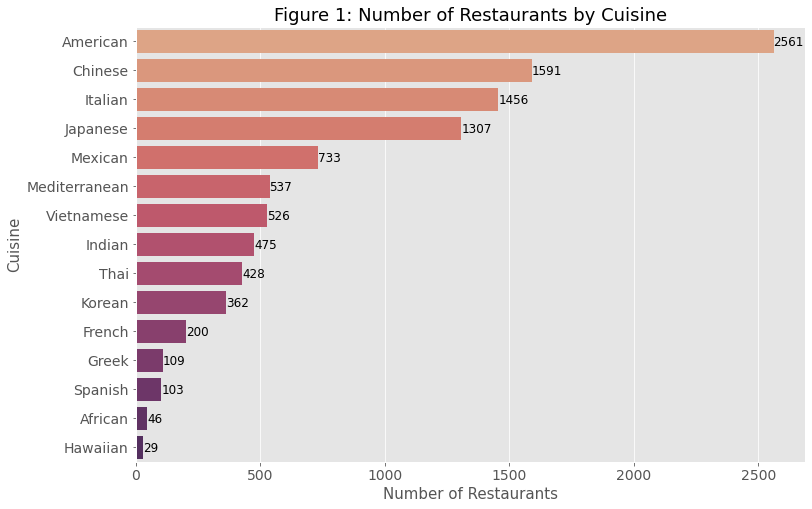

In [13]:
plt.figure(figsize=(12,8))
counts = bus_df.category.value_counts()
sns.countplot(y='category', data=bus_df, order=counts.index, 
              palette=sns.color_palette("flare", len(counts)))
plt.xlabel('Number of Restaurants', fontsize=15)
plt.ylabel('Cuisine', fontsize=15)
plt.title('Figure 1: Number of Restaurants by Cuisine', fontsize=18)
plt.tick_params(labelsize=14)
for  i, v in enumerate(counts):
    plt.text(v, i+0.15, str(v), fontsize=12)

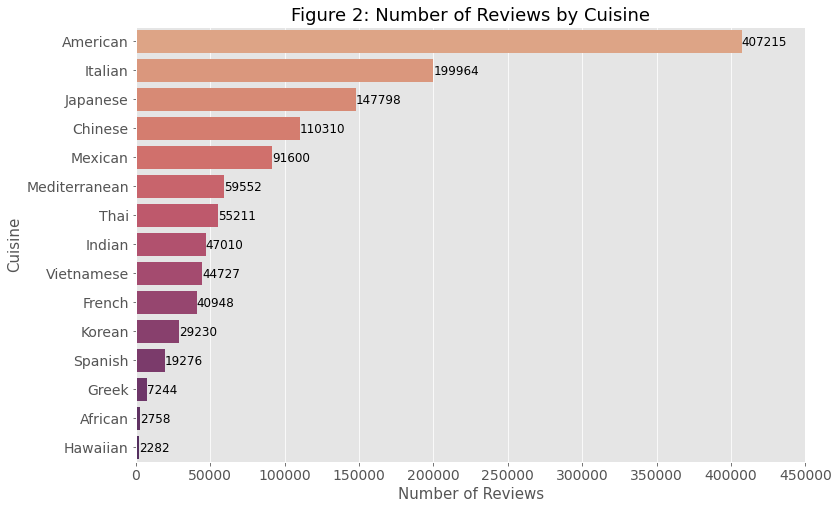

In [14]:
plt.figure(figsize=(12,8))
rev_counts = bus_df.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=rev_counts.index, x=rev_counts.values, 
            palette=sns.color_palette("flare", len(rev_counts)))
plt.ylabel('Cuisine', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=15)
plt.title('Figure 2: Number of Reviews by Cuisine', fontsize=18)
plt.tick_params(labelsize=14)
plt.xlim(0, 450000)
for i,v in enumerate(rev_counts):
    plt.text(v, i+0.15, str(v), fontsize=12)

Observe that Greek, African, and Hawaiian restaurants have significantly lower number of reviews. Such small amounts of data may lead to less meaningful results from NLP, and might not be as helpful in answering the research questions. As a result, we decided to remove these three types of cuisines. In future studies we could try better balance the review count of each cuisine.

In [15]:
cuisines = ['American', 'Chinese', 'French', 'Indian', 'Italian', 'Japanese', 'Korean', 
            'Mediterranean', 'Mexican',  'Spanish', 'Thai', 'Vietnamese']
cuisines_rem = ['African', 'Greek', 'Hawaiian']
for cuisine in cuisines_rem:
    df = df[df.category != cuisine]
    bus_df = bus_df[bus_df.category != cuisine]

Taking it a step further, we confirm the strong, positive correlation between amount of restaurants and amount of reviews in Figure 3.

Note that we have (rather naively) taken number of restaurants/reviews as a measure of cuisine popularity. But that's just the 'supply side' - what about popularity among restaurant-goers? Figure 4 takes average rating as a measure of cuisine popularity, and we observe a very interesting, somewhat negative correlation between average rating and amount of reviews. That is, the 'rarer' the cuisine is, the higher average rating it tends to get.

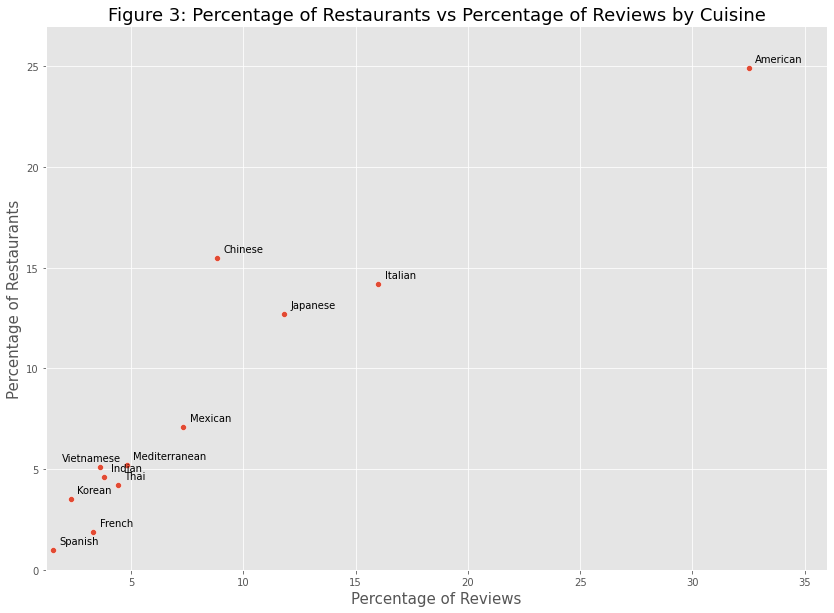

In [16]:
res = bus_df.category.value_counts()
rev = bus_df.groupby('category')['review_count'].sum()
res_percent = (res/bus_df.shape[0]*100).round(1)
rev_percent = (rev/df.shape[0]*100).round(1)

plt.figure(figsize=(14,10))
plt.ylim(0, 27)
plt.xlim(1.2, 36)
sns.scatterplot(y=res_percent, x=rev_percent, 
                palette=sns.color_palette("flare", 16))
plt.ylabel('Percentage of Restaurants', fontsize=15)
plt.xlabel('Percentage of Reviews', fontsize=15)
plt.title('Figure 3: Percentage of Restaurants vs Percentage of Reviews by Cuisine', fontsize=18)
for c in cuisines:
    if c == 'Vietnamese':
        plt.text(y=res_percent[c]+0.3,x=rev_percent[c]-1.7,s=c)
    else:
        plt.text(y=res_percent[c]+0.3,x=rev_percent[c]+0.3,s=c)

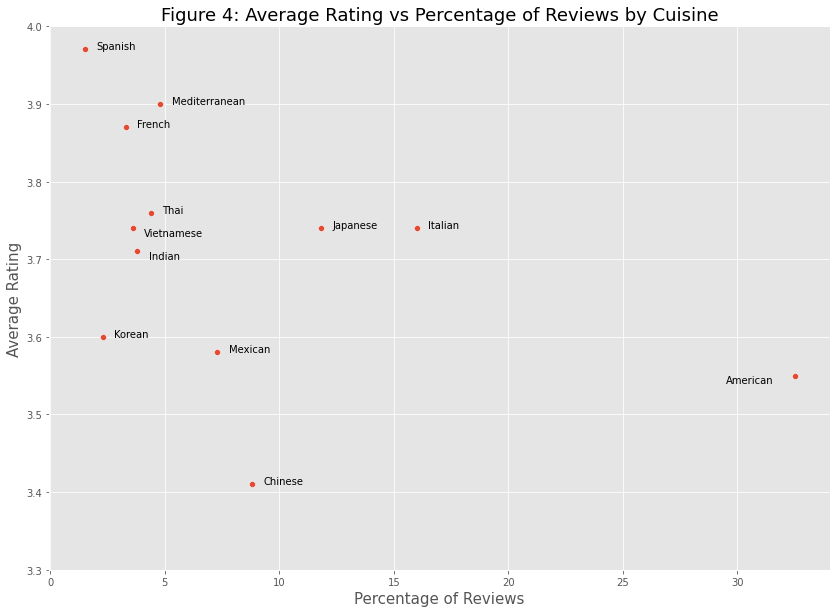

In [17]:
plt.figure(figsize=(14,10))
plt.ylim(3.3, 4)
rating = df.groupby('category')['rating'].mean().round(2)
rev = bus_df.groupby('category')['review_count'].sum()
rev_percent = (rev/df.shape[0]*100).round(1)


rating = df.groupby('category')['rating'].mean().round(2)
sns.scatterplot(y=rating.values, x=rev_percent, 
                palette=sns.color_palette("flare", 16))
plt.ylabel('Average Rating', fontsize=15)
plt.xlabel('Percentage of Reviews', fontsize=15)
plt.title('Figure 4: Average Rating vs Percentage of Reviews by Cuisine', fontsize=18)


for i in range(len(rating)):
    if rating.index[i] == 'Indian' or rating.index[i] == 'Vietnamese':
        plt.text(y=rating.values[i] - 0.01,x=rev_percent.values[i] + 0.5,s=rating.index[i])
    elif rating.index[i] == 'American':
        plt.text(y=rating.values[i] - 0.01,x=rev_percent.values[i]- 3,s=rating.index[i])
    else:
        plt.text(y=rating.values[i],x=rev_percent.values[i]+ 0.5,s=rating.index[i])

### Restaurant/Review Distribution

Now we'd like to better understand how restaurants and reviews are distributed. We find that while Massachusetts has slightly higher restaurant count (6,043 vs 4,236), it has significantly more reviews (980,079 vs 272,762).

Furthermore, it'd be interesting to see exactly where is contributing the most to these restaurants and reviews. Figure 5 and 6 show the top 10 cities with most restaurants and reviews respectively. Quite surprisingly, Vancouver and Boston are the major contributers by far, despite being just two cities. In fact, their reviews make up almost half of total reviews. This suggests that one possible extension is to incorporate more cities with similar number of reviews, so that the results might be more generalizable. Alternatively we could compare and contrast among these different locations.

Finally, we show the top 10 restaurants with most reviews in Figure 7. In some sense, these are the most 'popular' restaurants. They're mainly seafoods (not surprising given their proximity to the sea) and Italian food (Boston seems obsessed with it!).

In [18]:
state_counts = bus_df.state.value_counts()
review_counts = bus_df.groupby('state')['review_count'].sum()
for i in range(len(state_counts.index)):
    print("Now %s has %d restaurants with %d reviews in total." % (state_counts.index[i], state_counts.values[i], review_counts[(i+1)%2]))

Now MA has 6043 restaurants with 980079 reviews in total.
Now BC has 4236 restaurants with 272762 reviews in total.


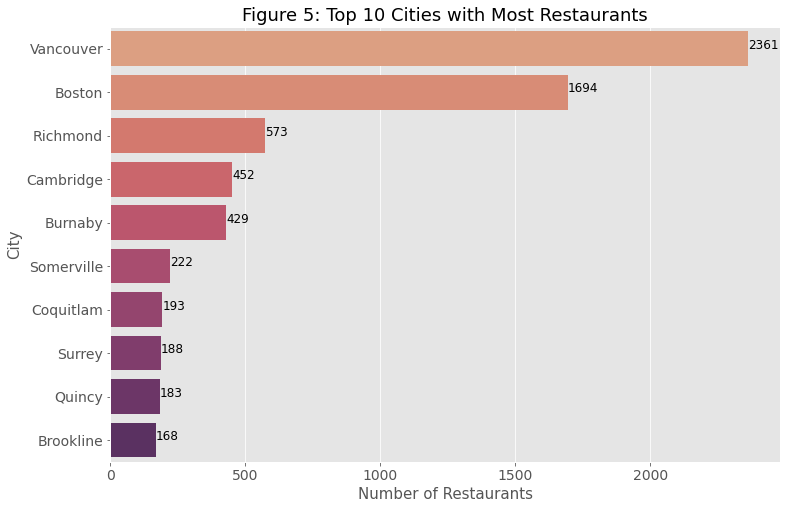

In [19]:
plt.figure(figsize=(12,8))
n = 10
city_counts = bus_df.city.value_counts()[:n]
sns.barplot(x=city_counts.values, y=city_counts.index,
            palette=sns.color_palette("flare", len(city_counts)))
plt.xlabel('Number of Restaurants', fontsize=15)
plt.ylabel('City', fontsize=15)
plt.title('Figure 5: Top 10 Cities with Most Restaurants', fontsize=18)
plt.tick_params(labelsize=14)
for  i, v in enumerate(city_counts):
    plt.text(v, i, str(v), fontsize=12)    

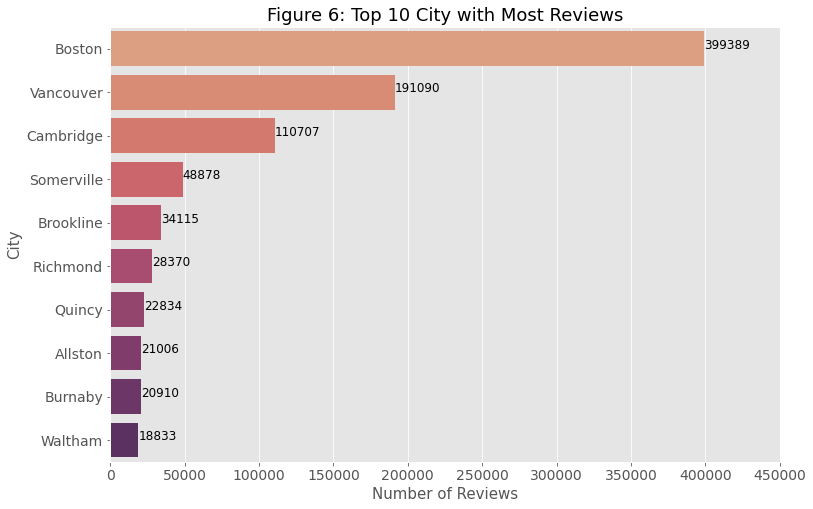

In [20]:
plt.figure(figsize=(12,8))
n = 10
rev_counts = bus_df.groupby('city')['review_count'].sum().sort_values(ascending = False)[:n]
sns.barplot(x=rev_counts.values, y=rev_counts.index,  
            palette=sns.color_palette("flare", len(rev_counts)))
plt.ylabel('City', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=15)
plt.title('Figure 6: Top 10 City with Most Reviews', fontsize=18)
plt.tick_params(labelsize=14)
plt.xlim(0, 450000)
for i,v in enumerate(rev_counts):
    plt.text(v, i, str(v), fontsize=12)

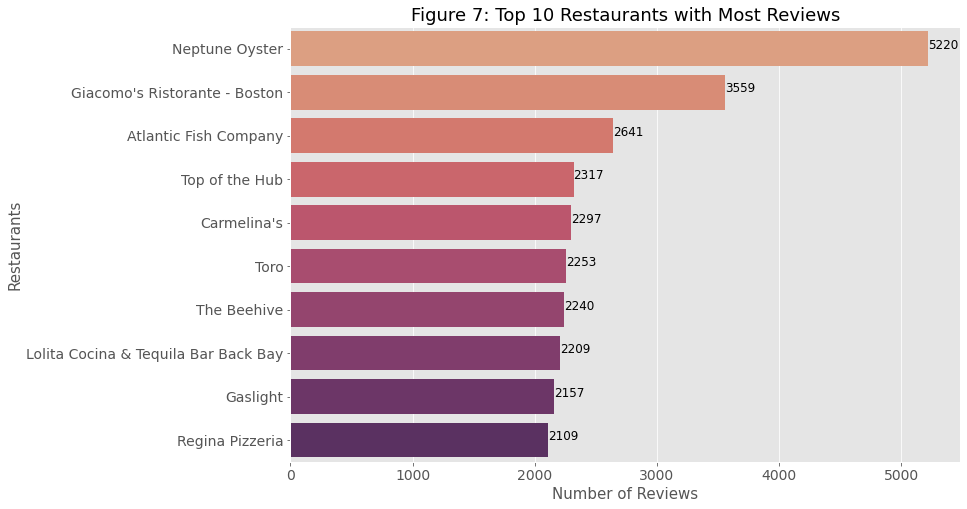

In [21]:
plt.figure(figsize=(12,8))
res = df[['name','review_count']].sort_values(by='review_count', ascending=False)
n = 10
res = res.drop_duplicates(subset = None)[:n]
sns.barplot(x=res.review_count, y = res.name,
            palette=sns.color_palette("flare", len(res)))
plt.xlabel('Number of Reviews', fontsize=15)
plt.ylabel('Restaurants', fontsize=15)
plt.title('Figure 7: Top 10 Restaurants with Most Reviews', fontsize=18)
plt.tick_params(labelsize=14)
for  i, v in enumerate(res.review_count):
    plt.text(v, i, str(v), fontsize=12)

Now we inspect the overall review distribution by restaurant in Figure 8. The top 1% restaurant outliers (mostly with more than 1000 reviews) have been removed to better display the distribution, and even then it's heavily right tailed. Most restaurants have less than 200 reviews, while a small portion has over 800. This makes sense since popular restaurants are usually less common, and people don't tend to write reviews for major restaurant chains like KFC and Starbucks (where each branch counts as one restaurant). 

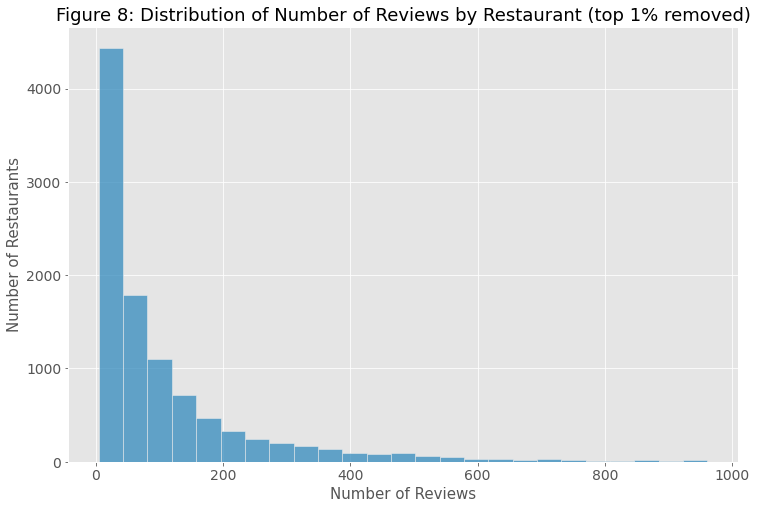

In [22]:
plt.figure(figsize=(12,8))
res = bus_df['review_count'].sort_values(ascending=False)[100:]
sns.histplot(x=res, palette=sns.color_palette("flare", len(res)), bins = 25)
plt.xlabel('Number of Reviews', fontsize=15)
plt.ylabel('Number of Restaurants', fontsize=15)
plt.title('Figure 8: Distribution of Number of Reviews by Restaurant (top 1% removed)', fontsize=18)
plt.tick_params(labelsize=14)

## Assigning Positive/Negative Labels

As part of sentiment analysis, we first assign each review a positive or negative label. This will be based on the rating given, where we decided to let 4 or 5 star be **positive**, and 1, 2, 3 star be **negative**. Figure 9 displays the number of reviews in each rating as reference, where we see most reviews have 4 or 5 stars. This may be due to people being more willing to spend time writing reviews on what they enjoyed.

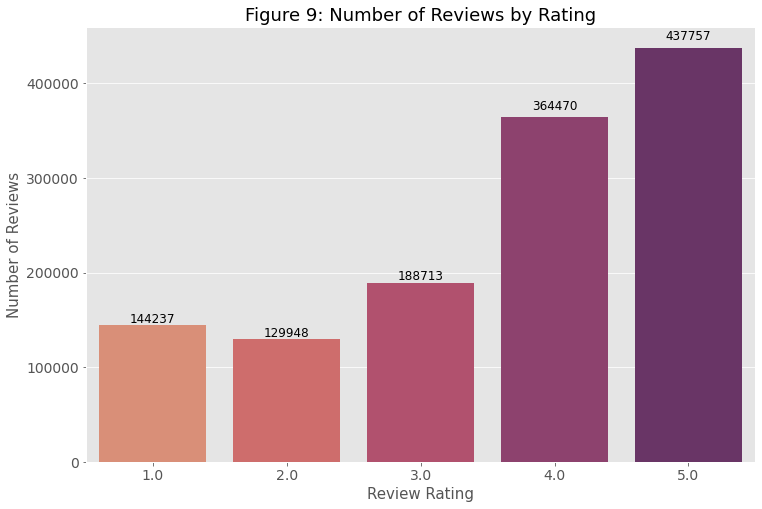

In [23]:
plt.figure(figsize=(12,8))
grouped = rev_df.rating.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values,
            palette=sns.color_palette("flare", len(grouped)))
plt.xlabel('Review Rating', fontsize=15)
plt.ylabel('Number of Reviews', fontsize=15)
plt.title('Figure 9: Number of Reviews by Rating', fontsize=18)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontsize=12)

In [24]:
# Label the reviews as positive or negative
df['label'] = ''
df.loc[df.rating >= 4, 'label'] = 'positive'
df.loc[df.rating <= 3, 'label'] = 'negative'

pt = pd.pivot_table(df, values=["id"], index=["category"], columns=["label"],
                    aggfunc=len, fill_value=0, margins=True)
pt_frac = pt.div(pt.iloc[:,-1], axis=0).iloc[:-1,-2]
pt_percent = (pt_frac*100).sort_values(ascending=False).round(1)

In [25]:
pt

id                  
label         negative positive      All
category                                
American        163779   243436   407215
Chinese          47768    62542   110310
French           12449    28499    40948
Indian           15839    31171    47010
Italian          67533   132431   199964
Japanese         50087    97711   147798
Korean           11005    18225    29230
Mediterranean    17179    42373    59552
Mexican          35569    56031    91600
Spanish           5099    14177    19276
Thai             18169    37042    55211
Vietnamese       14843    29884    44727
All             459319   793522  1252841

Figure 10 and 11 show the average rating and percentage of positive reviews by cuisine respectively. We see that Spanish and Mediterranean have over 70% positive reviews, while American and Chinese actually have the lowest percentage (but most restaurants). A higher average rating correlates with a higher percentage of positive rating as expected.

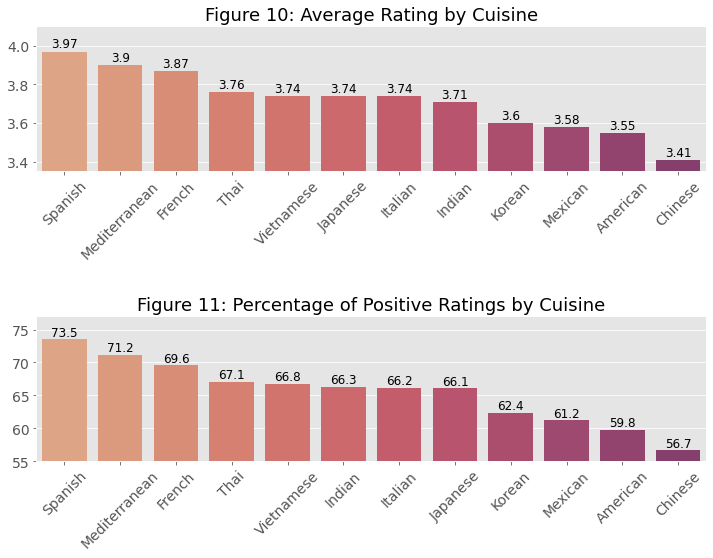

In [26]:
plt.figure(figsize=(12,8))
plt.subplot(211)
rating = df.groupby('category')['rating'].mean().sort_values(ascending=False).round(2)
sns.barplot(x=rating.index, y=rating.values,
            palette=sns.color_palette("flare", 16))
plt.xlabel('')
plt.title('Figure 10: Average Rating by Cuisine', fontsize=18)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45)
plt.ylim(3.35, 4.1)
for  i, v in enumerate(rating):
    plt.text(i, v+0.02, str(v), horizontalalignment='center', fontsize=12)
    
plt.subplot(212)
sns.barplot(x=pt_percent.index, y=pt_percent.values, 
            palette=sns.color_palette("flare", 16))
plt.xlabel('')
plt.title('Figure 11: Percentage of Positive Ratings by Cuisine', fontsize=18)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45)
plt.ylim(55, 77)
for  i, v in enumerate(pt_percent.round(2)):
    plt.text(i, v+0.5, str(v), horizontalalignment='center', fontsize=12)

plt.subplots_adjust(hspace=1)

## Sentiment Analysis

We train linear Support Vector Classification on the review data for each cuisine, and use the feature weights to obtain word polarity (i.e. how important a word is to the positive or negative sentiment). This allows us to obtain top positive and negative words for each cuisine for analysis.

### Pre-processing
First we perform the usual text preprocessing - converting to lower case and removing punctuations. We do not stem the words because instead we will filter them and keep only 'useful' ones. More specifically, from [NLP literature](http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), we obtained two lists of positive and negative opinion/sentiment words respectively. We will train our model based on words in these lists.

In [27]:
# Convert reviews to lower case
df['review'] = df.desc.str.lower()
df.review = df.review.str.translate(str.maketrans('', '', string.punctuation))
df.review= df.review.str.replace('\n','')

# Negative words
with open('negative.txt') as f:
    r = csv.reader(f)
    neg_words = [line[0] for line in r]

# Positive words
with open('positive.txt') as f:
    r = csv.reader(f)
    pos_words = [line[0] for line in r]

### SVM and Word Polarity

We now have the processed review texts and their labels. Note the importance of the positive/negative labels to the our supervised learning - word polarity is context specific. For instance, `big` is perceived as positive in `big portion` but is negative in `big stain on the tablecloth`.

We then train a linear SVM model using scikit-learn's `LinearSVC()` based on the texts and labels for each cuisine. However our goal is not prediction or classification, but rather the model's learned `coef_` (i.e. feature weights). Intuitively this vector is a set of weights orthogonal to, and representing a hyperplane decision boundary separating the predicted classes. Each input word has a corresponding weight, and the relative magnitude may indicate how important that word is for the separation (i.e. contribution to the sentiment), while the direction (sign) tells us which class the word is in. Call this the word score - so a word with positive score is probably a positive sentiment word, and vice versa. 

Note our use of a linear model is precisely because its weights are much easier to interpret than that of a general kernel. For example, this is the basis for the [RFE algorithm](https://axon.cs.byu.edu/Dan/778/papers/Feature%20Selection/guyon2.pdf) using the weight vector of linear SVM for feature selection.

In [28]:
def get_dataset(cuisine, df):
    """
    Get all the reviews and labels for a specific cuisine
    """
    return df[['review','label']][df.category==cuisine].reset_index(drop=True)

def filter_words(text):
    """
    Drop all words except those in the positive/negative list
    """
    return ' '.join([word for word in text.split() if word in pos_words + neg_words])

def get_word_polarity(review_data):
    """
    Returns the score and polarity of words in a given cuisine's restaurant reviews
    """
    # Update all the reviews to only include useful attitude words
    review_data.review = review_data.review.apply(filter_words)

    revs, y = list(review_data['review']), list(review_data['label'])

    # Getting the SVM model
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(revs)
    model = LinearSVC()
    model.fit(X, y)
   
    # Dataframe that stores the score of each word returned by the SVM model
    scores = model.coef_[0]
    words_score = pd.DataFrame({'score': scores, 'word': vectorizer.get_feature_names()})
    words_score.set_index('word', inplace=True)
    
    cuisine_reviews = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['label'] = y

    words_score['frequency'] = cuisine_reviews[cuisine_reviews['label'] == 'positive'].sum()[:-1]

    # Calculate polarity score
    words_score['polarity'] = pd.to_numeric(words_score.score * words_score.frequency / cuisine_reviews.shape[0])

    return words_score

def get_top_words_score(review_data, label, top=10):
    """
    Get top positive/negative words in the reviews for a given cuisine by coef_ score
    """
    if label == 'positive':
        return review_data.sort_values('score', ascending=False)[:top]
    else:
        return review_data.sort_values('score')[:top]

def get_top_words(review_data, label, top=10):
    """
    Get top positive/negative words in the reviews for a given cuisine by polarity
    """
    if label == 'positive':
        return review_data.sort_values('polarity', ascending=False)[:top]
    else:
        return review_data.sort_values('polarity')[:top]
    
def plot_top_words(top_words, cuisine):
    """
    Plot top positive and negative words in reviews for a given cuisine
    """
    plt.figure(figsize=(12,8))
    colors = ['blue' if s < 0 else 'red' for s in top_words.values]
    sns.barplot(x=top_words.values, y=top_words.index, palette=colors)
    plt.xlabel('Polarity Score', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.title('Top Positive and Negative Words in %s Restaurants ' % cuisine, fontsize=18)
    plt.tick_params(labelsize=14)
    
def rem_bad_words(review_data):
    """
    Filter out meaningless words that don't mean much in context
    """
    # Some meaningless words we encountered and decided to filter out
    bad_pos = ['great','amazing','love','best','awesome','excellent','good',
               'favorite','loved','perfect','gem','perfectly','wonderful',
               'happy','enjoyed','nice','well','super','like','better','decent','fine',
               'pretty','enough','excited','impressed','ready','fantastic','glad','right',
               'incredible', 'perfection', 'delightful']
    bad_neg =  ['bad','disappointed','unfortunately','disappointing',
                'lacking','terrible','sorry', 'mediocre', 'disappoint']
    bad_words = bad_pos + bad_neg
    bad_words = [w for w in bad_words if w in review_data.index]
    review_data = review_data.drop(review_data.loc[bad_words].index)
    return review_data

In [29]:
# Example usage: training model for Thai cuisine
# thai_df = get_dataset('Thai', df)
# thai_polarity = get_word_polarity(thai_df)
# thai_polarity_clean = rem_bad_words(thai_polarity)

### Scaling the scores and Removing Unnecessary Words

After training the model and sorting words by their `coef_` score magnitudes, we find that the top words (supposedly very positive sentiments) aren't that meaningful at all and have low frequency. An example with Thai cuisine is shown in the top table, where frequency is how often they appear in all reviews for a cuisine.

This motivates us to scale the scores by taking frequency into account, kind of like tf-idf. We decided to multiply each word's score by their frequency, and divided by the number of reviews in the cuisine, to get what we call the word polarity score. The resulting top words are vastly superior, very meaningful, and have high frequency, as shown in the bottom table. The top positive and negative words can also be visualized for better comparison of their polarity as shown below. Intuitively we're still using the magnitude of the polarity score as a measure of the importance of each word.

Finally, notice our use of the filter function `rem_bad_words()`, which filters out some of the unnecessary/meaningless words from the results. This is us applying our domain knowledge to the problem, where we know that while `excellent` and `fresh` may both carry very positive sentiments, `fresh` is a lot more meaningful in context as it suggests an attractive quality of restaurants.

Note that all model results are saved in the `scores` folder.

In [30]:
# Retrieve model result for Thai cuisine from folder
thai_polarity = pd.read_csv('scores/Thai.csv').set_index('word')

In [31]:
# Sorting by raw score, undesirable results
get_top_words_score(rem_bad_words(thai_polarity), 'positive', top=8)

,score,frequency,polarity
word,,,
infuriatingly,2.722522,1,0.000049
harmed,2.662533,2,0.000096
jaded,2.333084,5,0.000211
viewable,1.982144,3,0.000108
sublime,1.788481,36,0.001166
mesmerizing,1.732995,3,0.000094
undesirable,1.727380,2,0.000063
hooray,1.718142,16,0.000498


In [32]:
# Sorting by scaled score, desirable results
get_top_words(rem_bad_words(thai_polarity), 'positive', top=8)

,score,frequency,polarity
word,,,
delicious,0.375608,10576,0.071950
fresh,0.154194,7108,0.019851
friendly,0.158163,5726,0.016403
recommend,0.195236,4530,0.016019
hot,0.090102,4752,0.007755
authentic,0.147833,2722,0.007288
reasonable,0.184444,1730,0.005779
worth,0.078111,3532,0.004997


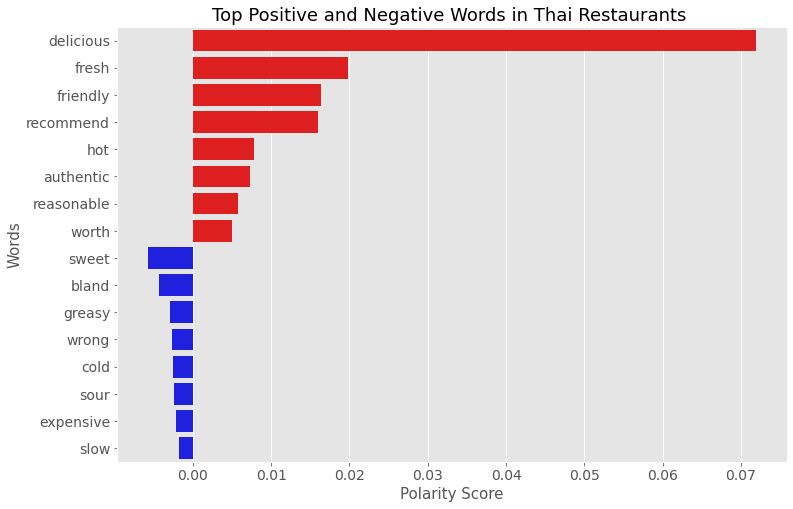

In [33]:
# Example of plotting top positive and negative words for Thai cuisine
n = 8
t = rem_bad_words(thai_polarity)
plot_top_words(pd.concat([t.sort_values('polarity', ascending=False)[:n],
                          t.sort_values('polarity')[:n]])['polarity'], 'Thai')

## Analysis of Results

### Comparing and Contrasting Top Words

We chose top 10 meaningful positive and negative words for each cuisine according to the words' polarity scores. Applying domain knowledge, we filtered out words that show sentiment yet don't imply specific characteristic about the restaurant. Common words we ignored include:
- **Positive**: great, nice, good, love, amazing, glad, super, etc.
- **Negative**: disappoint, bad, mediocre, worst, terrible, horrible, sorry, etc. 

We combined top words from each cuisine into one table below for ease of analysis. Words on the first row are the most "important" and the importance decreases as we go down. 

In [34]:
pos_compare = pd.read_csv("pos_words.csv")
neg_compare = pd.read_csv("neg_words.csv")

In [35]:
pos_compare

,American,Chinese,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Spanish,Thai,Vietnamese
0,delicious,delicious,delicious,delicious,delicious,delicious,delicious,delicious,delicious,delicious,delicious,delicious
1,friendly,authentic,recommend,friendly,friendly,fresh,recommend,friendly,fresh,friendly,fresh,friendly
2,recommend,fresh,friendly,recommend,recommend,recommend,friendly,fresh,friendly,recommend,friendly,fresh
3,fresh,friendly,tender,fresh,fresh,friendly,happy,recommend,recommend,happy,recommend,recommend
4,fun,recommend,delightful,authentic,reasonable,reasonable,fresh,reasonable,authentic,fun,hot,reasonable
5,happy,reasonable,reasonable,happy,worth,happy,tender,happy,fast,perfection,authentic,happy
6,attentive,hot,happy,reasonable,perfection,hot,authentic,fast,reasonable,sweet,reasonable,fast
7,cozy,fast,heaven,hot,authentic,right,generous,authentic,affordable,attentive,right,worth
8,helpful,happy,helpful,attentive,happy,worth,fast,healthy,hot,fresh,happy,recommended
9,fast,worth,rich,generous,cozy,fun,free,recommended,worth,heaven,perfection,tender


In [36]:
neg_compare

,American,Chinese,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Spanish,Thai,Vietnamese
0,slow,bland,cold,bland,cold,slow,bland,cold,bland,cold,sweet,bland
1,cold,expensive,slow,cold,slow,expensive,expensive,slow,cold,bland,bland,slow
2,hard,hard,bland,slow,bland,bland,slow,bland,slow,slow,greasy,hard
3,expensive,greasy,hard,expensive,wrong,hard,cold,hard,expensive,overpriced,wrong,greasy
4,overpriced,cold,expensive,hard,hard,wrong,overpriced,expensive,wrong,expensive,cold,sweet
5,bland,sour,overpriced,wrong,expensive,cold,tough,wrong,hard,lacking,sour,wrong
6,loud,slow,tough,sweet,overpriced,overpriced,weird,overpriced,overpriced,problem,expensive,lacking
7,wrong,mediocre,enough,overpriced,loud,weird,frozen,rude,loud,issue,slow,expensive
8,greasy,rude,lacking,lacking,rude,lacking,lacking,greasy,sour,lack,hard,weird
9,problem,sweet,limited,poor,poor,poor,wrong,poor,rude,wrong,tough,tough


### Inferences

First, there are many similarities in these cuisines' top words. **Delicious** ranks first in every cuisine's positive words, suggesting that tastes are indeed what most people look for first. This is followed by words like **friendly** and **attentive**, pointing to service. As for negative words, all share a distaste for **bland** and **slow** - again taste and service. In addition price is also a major factor.

However, there are also differences (mainly in positive words), particularly when we focus on details. For example, **delicious** may mean different things in different cuisines - while it's **tender** for French and Korean, it's **fresh** for Japanese and Vietnamese, and it's **authentic** for Mexican and Indian.

From these top meaningful positive/negative words we can make inference on what customers emphasize or mainly care about. This can be especially valuable to restaurant owners seeking possible improvements. Below is a very general summary of some of the restaurant characteristics that might be the most important to customers for a given cuisine, and much more factors can be learned by further analysing the resulting words.
- **American**: Environment and service
- **Chinese**: Food flavor and reasonable price
- **French**: Food flavor, service and reasonable price
- **Indian**: Service and reasonable price
- **Italian**: Environment and reasonable price
- **Japanese**: Reasonable price and service
- **Korean**: Food texture and reasonable price
- **Mediterranean**: Health and reasonable price
- **Mexican**: Reasonable, cheap price
- **Spanish**: Environment and reasonable price
- **Thai**: Food flavor and quality
- **Vietnamese**: Food flavor 


## Related Work

Yelp is a popular source of data and [Data Science projects](https://www.yelp.com/dataset/challenge/winners). Much work has been done with review data, such as [predicting ratings](https://arxiv.org/pdf/2012.06690.pdf), [identifying potential customers](https://s3-media0.fl.yelpcdn.com/assets/srv0/engineering_pages/f63a086ef2a3/assets/vendor/pdf/DSC_R09_CORALSWhoAreMyPotentialNewCustomers.pdf), and [predicting the number of reviews](https://www.yelp.com/html/pdf/YelpDatasetChallengeWinner_InferringFuture.pdf). Sentiment analysis of yelp reviews has been done, but mainly for [classification purposes](https://arxiv.org/pdf/1710.05978.pdf). Discovering factors that are important for restaurants has also been worked on, but often not using the [SVM model](https://www.yelp.com/html/pdf/YelpDatasetChallengeWinner_ImprovingRestaurants.pdf).



## Possible Extensions

There exist many possible extensions. For data, we could incorporate more locations, which allows for either more generalizable results if combined, or more distinct results if compared. For methodology, we could discover and test other ways of scaling the `coef_` scores, as well as how to better filter words. For analysis, we could discover a lot more with just current top words by inspecting more words and going into detail (e.g. different attributes of delicious). Finally, our processed dataset already contains location and price information, which means we could categorize by them rather than cuisine for compare and contrast.